# 数据预处理

## 一、合并 train + test
去掉 Id、train 去掉 SalePrice

保证 one-hot 维度一致

避免 test 出现 train 没有的类别

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
all_features = pd.concat((train.iloc[:, 1:-1], test.iloc[:, 1:]))

## 二、数值特征标准化

In [4]:
numberic_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numberic_features] = all_features[numberic_features].apply(
    lambda x:(x-x.mean())/x.std())
all_features[numberic_features] = all_features[numberic_features].fillna(0)

## 三、类别特征 one-hot
特征由79个增加到了330个

In [5]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

## 四、拆回 train/test并转换为张量

In [6]:
all_features = all_features.astype(float)
n_train = train.shape[0]

train_features = torch.tensor(
    all_features[:n_train].values,
    dtype=torch.float32
)

test_features = torch.tensor(
    all_features[n_train:].values,
    dtype=torch.float32
)

train_labels = torch.tensor(
    train.SalePrice.values.reshape(-1,1),
    dtype=torch.float32
)

In [7]:
all_features.dtypes.value_counts()
train_features.shape,test_features.shape

(torch.Size([1460, 330]), torch.Size([1459, 330]))

## 五、对标签对log变换

In [8]:
train_labels = torch.log1p(train_labels)

# 训练

## 一、定义网络

In [10]:
in_feature = train_features.shape[1]

net = nn.Sequential(nn.Linear(in_feature,1))

## 二、定义loss和优化器

In [11]:
loss = nn.MSELoss()

optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.01,
    weight_decay=0 #先观察未使用L2正则时
)

## 三、定义训练函数

In [12]:
def train(net,train_features,train_labels,
         num_epochs=100,lr=0.01,weight_decay=0):
    
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    train_ls = []

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        l = loss(net(train_features),train_labels)
        l.backward()
        optimizer.step()

        train_ls.append(l.item())

        if (epoch + 1)%20 == 0:
            print(f"epoch:{epoch+1},loss:{l.item():.6f}")
    return train_ls

In [13]:
train_ls = train(
    net,
    train_features,
    train_labels,
    num_epochs=200,
    lr=0.01
)

epoch:20,loss:17.545328
epoch:40,loss:0.378198
epoch:60,loss:0.363586
epoch:80,loss:0.042653
epoch:100,loss:0.029277
epoch:120,loss:0.024519
epoch:140,loss:0.021920
epoch:160,loss:0.020148
epoch:180,loss:0.018618
epoch:200,loss:0.017296


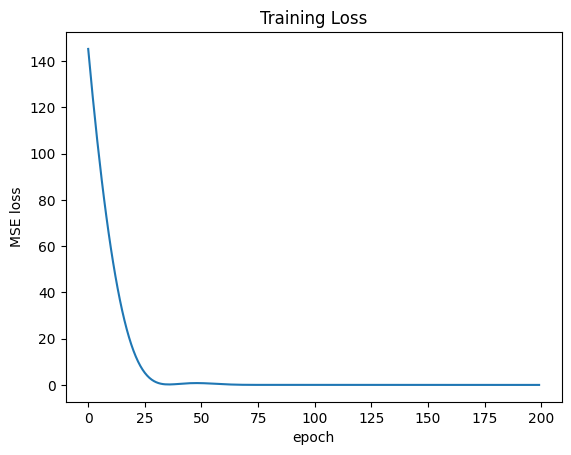

In [16]:
plt.plot(train_ls)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Training Loss")
plt.show()

200次训练后，loss最终下降到了loss:0.017296，loss曲线快速下降并且平滑，未发生梯度爆炸

## 四、模型升级

增加一个隐藏层，并用ReLu函数激活

In [18]:
net = nn.Sequential(
    nn.Linear(in_feature,128),
    nn.ReLU(),
    nn.Linear(128,1)
)

加入L2正则

In [27]:
def train(net, train_features, train_labels,
          num_epochs=200, lr=0.01, weight_decay=1e-3):

    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    
    train_ls = []

    for epoch in range(num_epochs):
        net.train()
        
        optimizer.zero_grad()
        l = loss(net(train_features), train_labels)
        l.backward()
        optimizer.step()
        
        train_ls.append(l.item())

    return train_ls

In [19]:
train_ls = train(
    net,
    train_features,
    train_labels,
    num_epochs=300,
    lr=0.01,
    weight_decay=1e-3
)

epoch:20,loss:6.404667
epoch:40,loss:0.152817
epoch:60,loss:0.141872
epoch:80,loss:0.014821
epoch:100,loss:0.013546
epoch:120,loss:0.011982
epoch:140,loss:0.011285
epoch:160,loss:0.010853
epoch:180,loss:0.010538
epoch:200,loss:0.010324
epoch:220,loss:0.010157
epoch:240,loss:0.010024
epoch:260,loss:0.009911
epoch:280,loss:0.009811
epoch:300,loss:0.009726


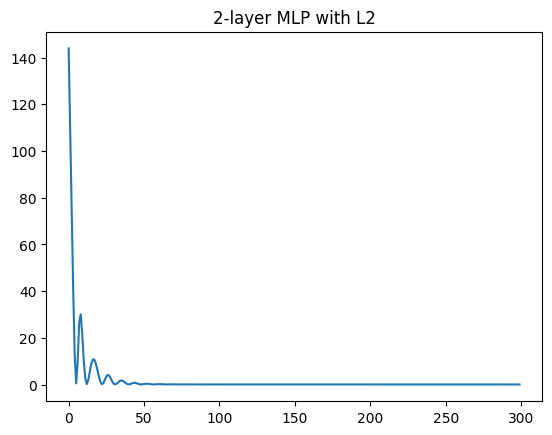

In [20]:
plt.plot(train_ls)
plt.title("2-layer MLP with L2")
plt.show()

loss 更低

收敛更快

有震荡

可能是lr偏大，或者模型变复杂导致的

## K-Fold

In [22]:
def get_k_fold_data(k,i,X,y):
    fold_size = X.shape[0] // k
    X_train,y_train = None,None
    X_valid,y__valid = None,None

    for j in range(fold_size):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j == i:
            X_valid,y__valid = X_part,y_part
        else:
            if X_train == None:
                X_train,y_train = X_part,y_part
            else:
                X_train = torch.cat([X_train, X_part], 0)
                y_train = torch.cat([y_train, y_part], 0)
    return X_train,y_train,X_valid,y__valid

In [25]:
def k_fold(k, X, y, num_epochs=200, lr=0.01, weight_decay=1e-3):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        net = nn.Sequential(
            nn.Linear(in_feature, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        X_train, y_train, X_valid, y_valid = \
            get_k_fold_data(k, i, X, y)
        
        train_ls = train(
            net, X_train, y_train,
            num_epochs, lr, weight_decay
        )
        
        valid_loss = loss(net(X_valid), y_valid).item()
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_loss
        
        print(f"fold {i}, valid loss {valid_loss:.6f}")
     
    return train_l_sum / k, valid_l_sum / k

In [32]:
train_loss, valid_loss = k_fold(
    5,
    train_features,
    train_labels,
    num_epochs=200,
    lr=0.01,
    weight_decay=1e-3
)

print(f"avg train loss: {train_loss:.5f}")
print(f"avg valid loss: {valid_loss:.5f}")

fold 0, valid loss 0.018915
fold 1, valid loss 0.025314
fold 2, valid loss 0.021621
fold 3, valid loss 0.014389
fold 4, valid loss 0.075660
avg train loss: 0.00946
avg valid loss: 0.03118


train << valid，过拟合了，考虑后续加入dropout

In [33]:
def k_fold(k, X, y, num_epochs=200, lr=0.01, weight_decay=1e-3):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        net = nn.Sequential(
            nn.Linear(in_feature, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
        X_train, y_train, X_valid, y_valid = \
            get_k_fold_data(k, i, X, y)
        
        train_ls = train(
            net, X_train, y_train,
            num_epochs, lr, weight_decay
        )
        
        valid_loss = loss(net(X_valid), y_valid).item()
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_loss
        
        print(f"fold {i}, valid loss {valid_loss:.6f}")
     
    return train_l_sum / k, valid_l_sum / k

In [34]:
train_loss, valid_loss = k_fold(
    5,
    train_features,
    train_labels,
    num_epochs=200,
    lr=0.01,
    weight_decay=1e-3
)

print(f"avg train loss: {train_loss:.5f}")
print(f"avg valid loss: {valid_loss:.5f}")

fold 0, valid loss 2.188235
fold 1, valid loss 2.237819
fold 2, valid loss 2.443639
fold 3, valid loss 2.006131
fold 4, valid loss 2.338711
avg train loss: 2.20747
avg valid loss: 2.24291


loss激增到2点几，表明模型学不动了，直接从过拟合变成欠拟合了

表格数据 + 小样本 + MLP

容易过拟合

Dropout 效果很差

调参空间很小

这个数据集可能树模型比MLP更合适，缩小模型规模试试

In [35]:
def k_fold(k, X, y, num_epochs=200, lr=0.01, weight_decay=1e-3):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        net = nn.Sequential(
            nn.Linear(in_feature, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        X_train, y_train, X_valid, y_valid = \
            get_k_fold_data(k, i, X, y)
        
        train_ls = train(
            net, X_train, y_train,
            num_epochs, lr, weight_decay
        )
        
        valid_loss = loss(net(X_valid), y_valid).item()
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_loss
        
        print(f"fold {i}, valid loss {valid_loss:.6f}")
     
    return train_l_sum / k, valid_l_sum / k

In [36]:
train_loss, valid_loss = k_fold(
    5,
    train_features,
    train_labels,
    num_epochs=200,
    lr=0.01,
    weight_decay=1e-3
)

print(f"avg train loss: {train_loss:.5f}")
print(f"avg valid loss: {valid_loss:.5f}")

fold 0, valid loss 0.016012
fold 1, valid loss 0.024220
fold 2, valid loss 0.018319
fold 3, valid loss 0.013695
fold 4, valid loss 0.053153
avg train loss: 0.00981
avg valid loss: 0.02508


有改进，对baseline做5-fold比较

In [37]:
def k_fold(k, X, y, num_epochs=200, lr=0.01, weight_decay=1e-3):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        net = nn.Sequential(
            nn.Linear(in_feature, 1),
        )
        X_train, y_train, X_valid, y_valid = \
            get_k_fold_data(k, i, X, y)
        
        train_ls = train(
            net, X_train, y_train,
            num_epochs, lr, weight_decay
        )
        
        valid_loss = loss(net(X_valid), y_valid).item()
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_loss
        
        print(f"fold {i}, valid loss {valid_loss:.6f}")
     
    return train_l_sum / k, valid_l_sum / k

In [38]:
train_loss, valid_loss = k_fold(
    5,
    train_features,
    train_labels,
    num_epochs=200,
    lr=0.01,
    weight_decay=0
)

print(f"avg train loss: {train_loss:.5f}")
print(f"avg valid loss: {valid_loss:.5f}")

fold 0, valid loss 0.023399
fold 1, valid loss 0.030604
fold 2, valid loss 0.019883
fold 3, valid loss 0.020566
fold 4, valid loss 0.046301
avg train loss: 0.01650
avg valid loss: 0.02815


# 结果汇总
🔹 线性模型

avg train loss: 0.01650

avg valid loss: 0.02815

🔹 MLP (128 隐藏层)

avg train loss: 0.00946

avg valid loss: 0.03118

→ 明显过拟合

🔹 MLP (32 隐藏层)

avg train loss: 0.00981

avg valid loss: 0.02508

注意到fold 4, valid loss 0.053153，这表明数据分布不均匀，在这一折上可能有更多的异常数据